# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

A disparity map measures the difference in apparent positions of the same object as observed in the two images, and can be related to the depth of the object (as closer objects have a higher disparity). We use openCV's StereoSGBM functionality to calculate this map, which uses Semi-Global Block Matching to calculate corresponding points and then measures the differences in their apparent positions. So the StereoSGBM matches blocks, and not individual pixels. Though, setting blockSize=1 reduces the blocks to single pixels. StereoSGB uses several parameters:

minDisparity:       Minimum possible disparity value. Normally, it is zero but sometimes rectification algorithms can shift images which can lead to arbitrary values.  
numDisparities:     Maximum disparity minus minimum disparity.  
blockSize:      Matched block size. It must be an odd number >=1.  
disp12MaxDiff:      Maximum allowed difference (in integer pixel units) in the left-right disparity check.  
preFilterCap:       Truncation value for the prefiltered image pixels. The algorithm first computes x-derivative at each pixel and clips its value by [-preFilterCap, preFilterCap] interval. The result values are passed to the Birchfield-Tomasi pixel cost function.   

uniquenessRatio:    Margin in percentage by which the best (minimum) computed cost function value should win the second best value to consider the found match correct.   
speckleWindowSize:  Maximum size of smooth disparity regions to consider their noise speckles and invalidate.  
speckleRange:   Maximum disparity variation within each connected component.     

P1:    The first parameter controlling the disparity smoothness. Used for the case of slanted surfaces.  
P2:    The second parameter controlling the disparity smoothness.This parameter is used for solving the depth discontinuities problem. The larger the values are, the smoother the disparity is. P1 is the penalty on the disparity change by plus or minus 1 between neighbor pixels. P2 is the penalty on the disparity change by more than 1 between neighbor pixels.  


Heavy parameter tuning was required to achieve acceptable disparity results. We divide our disparity images by 64, which is a multiple of 16, to ensure that it fits the requirement needed reprojectImageTo3D. Choosing 64 gave us better results than 32. Later, to get a better control over the reprojection process we implemented our own reprojectImageTo3D function. For that we converted the disparity matrix into a disparity flattened array and then later extracted the inverse_projected 3D points directly. Next, we calculate the reverse projection matrix, which uses the dimensions of the image, the focal distance and the baseline, and along with the disparity information, helps to reproject the image points back into the 3D world.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import random 
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-12-03 01:11:01,173 - utils - NumExpr defaulting to 8 threads.


In [2]:
def read_transformations(filename):
    f = open(filename, 'r')
    pose_data = np.loadtxt(f)
    transformation_list = pose_data.reshape(len(pose_data),3,4)
    return transformation_list

POSES_PATH = "../data/poses.txt"
LEFT_IMAGES_DIR_PATH = "../data/img2"
RIGHT_IMAGES_DIR_PATH = "../data/img3"
RESULTS_PATH = 'point_clouds'

K = [[7.070912e+02, 0.000000e+00, 6.018873e+02], [0.000000e+00, 7.070912e+02, 1.831104e+02], [0.000000e+00, 0.000000e+00, 1.000000e+00]]
BASELINE = 0.53790448812
TRANS = np.loadtxt(POSES_PATH)

In [3]:
NUM_DISPARITIES = 144
BLOCK_SIZE = 5
UNIQUENESS_RATIO = 10
SPECKLE_RANGE = 32
WINDOW_SIZE = 5
MIN_DISPARITY = -39
DISP_12_MAX_DIFF = 1
SPECKLE_WINDOW_SIZE = 100

In [4]:
def project_points_to_world(points,pose):
    points = (pose @ points.T).T
    return points

def getParallaxMap(disparity):
    h,w = disparity.shape
    disparity_map = []
    for i in range(h):
        for j in range(w):
            disparity_map.append([j,i,disparity[i,j],1])
    return np.array(disparity_map)

def reprojectImageTo3d(disparity_map,Q):
    points = []
    for dis in disparity_map:
        point = Q @ dis
        points.append(point)
    return np.array(points)

def make_disparitymap(imgL, imgR):
    
    # Hyperparameters
    win_size = WINDOW_SIZE 
    min_disp = MIN_DISPARITY 
    num_disp = NUM_DISPARITIES 
        
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        blockSize = BLOCK_SIZE,
        disp12MaxDiff = DISP_12_MAX_DIFF,
        speckleWindowSize = SPECKLE_WINDOW_SIZE,
        speckleRange = SPECKLE_RANGE,
        uniquenessRatio = UNIQUENESS_RATIO,
        P1 = 8*3* win_size**2,
        P2 = 32*3*win_size**2,
        preFilterCap = 63
    )
        
    disparity = stereo.compute(imgL, imgR).astype(np.float32)/64.0
    disparity = (disparity-min_disp)/num_disp
    return disparity

def filter(point_cloud,cloud_colors,beta=1490):
    mask = ((-beta <= point_cloud[:,1]) & (point_cloud[:,1] < beta) &
        (-beta <= point_cloud[:,2]) & (point_cloud[:,2] < beta) &
        (-beta <= point_cloud[:,0]) & (point_cloud[:,0] < beta))

    point_cloud = point_cloud[mask]
    cloud_colors = cloud_colors[mask]
    point_cloud[:,0] *= -1
    return point_cloud,cloud_colors


In [6]:
i_ = 0
world_pcd = o3d.geometry.PointCloud()

for file_name in sorted(os.listdir(LEFT_IMAGES_DIR_PATH)):
    
    img_left = os.path.join(LEFT_IMAGES_DIR_PATH, file_name)
    img_right = os.path.join(RIGHT_IMAGES_DIR_PATH, file_name)

    img_left = cv2.imread(img_left)
    img_right = cv2.imread(img_right)

    disparity = make_disparitymap(img_left, img_right)

    h, w = disparity.shape[:2]
    f = K[0][0]
    rev_proj_matrix = np.float32([[1, 0, 0, -0.5*w],
                        [0,-1, 0,  0.5*h],
                        [0, 0, 0, f],
                        [0, 0, 1/BASELINE,  0]])
    disparity_map = getParallaxMap(disparity)
    point_cloud = reprojectImageTo3d(disparity_map, rev_proj_matrix)

    colors = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    mask = (disparity >= disparity.min())
    colors = colors[mask]

    colors = colors/255
    cloud_colors = np.array(colors)

    point_cloud = (point_cloud.T/point_cloud.T[3,:]).T
    point_cloud = project_points_to_world(point_cloud,TRANS[i_].reshape((3, 4)))

    point_cloud,cloud_colors = filter(point_cloud,cloud_colors)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(cloud_colors)
    world_pcd += pcd

    i_ += 1
        
o3d.io.write_point_cloud("colored_op.pcd", world_pcd)

True

In [8]:
output = o3d.io.read_point_cloud("colored_op.pcd")
o3d.visualization.draw_geometries([output])

![world_pcd.png](../misc/world_pcd.jpeg)   

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.

Structure of the jacobian and residual is derived in `Theory.pdf` file.

In [299]:
def get_correspondences(world_pcd, sample_count = 100):
    #Initialising R and t:
    mu, sigma = 0, 0.1
    R = np.random.normal(mu, sigma, (3, 3))
    t = np.random.normal(mu, sigma, (3, 1))
    R_t = np.hstack((R,t))  #3x4 translation matrix

    #get P:
    P = K @ R_t

    points = np.asarray(world_pcd.points)

    points_2d = []
    points_3d = []

    rand_ind = np.random.randint(0,points.shape[0],size=sample_count)

    for i in rand_ind:

        x_est = P @ np.hstack((points[i], [1]))
        points_3d.append(np.hstack((points[i], [1])))
        points_2d.append(x_est)

    points_3d = np.array(points_3d)
    points_2d = np.array(points_2d)

    return points_2d, points_3d, P

In [300]:
# UTILITY FUNCTIONS

def get_residual(points_2d,points_3d,P):
    P = P.reshape((3, 4))
    r = (points_2d - points_3d @ P.T)**2
    r = np.sum(r,axis=1)
    return r

def get_jacobian(points_2d, points_3d, P):
    J = np.zeros((points_2d.shape[0], 12))
    P = P.reshape((12, 1))

    for i in range(points_2d.shape[0]):

        x1, x2, x3 = points_2d[i]
        X1, X2, X3, X4 = points_3d[i]
        r1 = x1 - P[0]*X1 - P[1]*X2 - P[2]*X3  - P[3]*X4
        r2 = x2 - P[4]*X1 - P[5]*X2 - P[6]*X3  - P[7]*X4
        r3 = x3 - P[8]*X1 - P[9]*X2 - P[10]*X3 - P[11]*X4

        J[i][0], J[i][1], J[i][2], J[i][3] = -2*r1*X1, -2*r1*X2, -2*r1*X3, -2*r1*X4
        J[i][4], J[i][5], J[i][6], J[i][7] = -2*r2*X1, -2*r2*X2, -2*r2*X3, -2*r2*X4
        J[i][8], J[i][9], J[i][10], J[i][11] = -2*r3*X1, -2*r3*X2, -2*r3*X3, -2*r3*X4
        
    return J

def gauss_newton(points_2d, points_3d, P_init,iter, tolerance = 1e-10):

    #Storing initial cost function
    r_p = get_residual(points_2d, points_3d, P_init)
    cost_func = [np.sum(r_p)]

    P_est = P_init

    for i in range(iter):

        #Jacobian of residual
        Jr = get_jacobian(points_2d, points_3d, P_est)

        #Error function
        r_p = get_residual(points_2d,points_3d,P_est)

        #Store current cost funciton
        cost_func.append(np.sum(r_p))

        #Updating parameters
        del_p = -np.linalg.pinv(Jr.transpose() @ Jr) @ Jr.transpose() @ r_p
        P_updated = P_est + del_p.reshape((12, 1))       #Store new parameters

        # If the differences b/w all values of updated parameters and their corresponding values of current parameters are less than tolerance:
        if(np.all(P_updated-P_est)<tolerance):
            return P_updated,cost_func

        #Update parameters
        P_est = P_updated

    return P_est,cost_func

def PnP(points_2d, points_3d, P_init, iterations = 100, tol = 1e-15):
    return gauss_newton(points_2d, points_3d, P_init, iterations, tol)


In [301]:
points_2d, points_3d, P_gt_unnorm = get_correspondences(world_pcd)
mu, sigma = 100, 100
P_init_unnormm = P_gt_unnorm.reshape((12,1)) + np.random.normal(mu, sigma, (12, 1))

P_out_unnorm, error_unnorm = PnP(points_2d, points_3d, P_init_unnormm)
P_out_unnorm = P_out_unnorm.reshape((3, 4))

print("Ground truth P=\n",P_gt_unnorm) 
print("Randomly initialised P=\n",P_init_unnormm.reshape((3,4)))
print("Final optimised P=\n", P_out_unnorm)
print("The error value =", error_unnorm[-1])


Ground truth P=
 [[-3.05264896e+01 -5.18807847e+01  2.81603787e+01  4.43704717e+00]
 [ 9.59556815e+01 -1.93950526e+01  3.54278273e+01  4.79300815e+01]
 [-6.59758933e-02  5.15221731e-02 -3.70474442e-02  5.29744064e-02]]
Randomly initialised P=
 [[  6.52513002  79.46195569 119.86767955  16.43428461]
 [-35.03314333 -47.91297296 160.95381336  49.76327317]
 [ 20.86455659 198.79033304 251.27990217 141.57920702]]
Final optimised P=
 [[-3.05264896e+01 -5.18807847e+01  2.81603787e+01  4.43704717e+00]
 [ 9.59556815e+01 -1.93950526e+01  3.54278273e+01  4.79300815e+01]
 [-6.59758933e-02  5.15221731e-02 -3.70474442e-02  5.29744063e-02]]
The error value = 7.490913590771438e-13


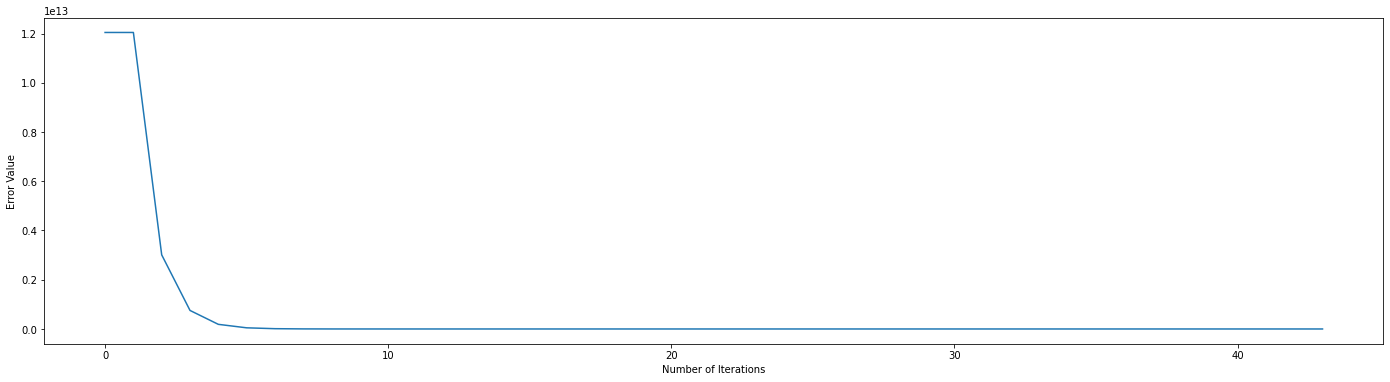

In [302]:
ROWS, COLS = 1, 3
H, W = 6, 8

fig, ax = plt.subplots(figsize = (COLS*W, ROWS*H))

ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Error Value")
ax.plot(error_unnorm)

### Normalised PnP:

In [303]:
def get_jacobian_normalized(x, X, Pk):
    
    J = np.zeros((2*len(x), 12))
    
    x_pred = (Pk @ X.T).T
    Z = x_pred[:,2]
    
    # Update for xi
    J[::2, 0] = -X[:,0] / Z
    J[::2, 1] = -X[:,1] / Z 
    J[::2, 2] = -X[:,2] / Z
    J[::2, 3] = -1 / Z
    J[::2, 8] = X[:,0] * x_pred[:,0] / (Z**2)
    J[::2, 9] = X[:,1] * x_pred[:,0] / (Z**2) 
    J[::2,10] = X[:,2] * x_pred[:,0] / (Z**2) 
    J[::2,11] = 1 / (Z**2)
    
    # Update for yi
    J[1::2, 4] = -X[:,0] / Z
    J[1::2, 5] = -X[:,1] / Z
    J[1::2, 6] = -X[:,2] / Z
    J[1::2, 7] = -1 / Z
    J[1::2, 8] = X[:,0] * x_pred[:,1] / (Z**2)
    J[1::2, 9] = X[:,1] * x_pred[:,1] / (Z**2)
    J[1::2,10] = X[:,2] * x_pred[:,1] / (Z**2)
    J[1::2,11] = 1 / (Z**2)

    return J
    
def gauss_newton_normalized(x, X, P0, n_iters = 20, lmbda = 10):
    P0 = P0.reshape((3,4))
    Pk = P0.copy()
    x = x / x[:,2].reshape(-1,1)
    errors = []
    
    for k in range(n_iters):
        
        # current projection calculation
        x_pred = (Pk @ X.T).T
        x_pred = x_pred / x_pred[:,2].reshape(-1,1)

        # residual calculation
        r = x - x_pred

        # error calculation
        err = np.sum(r**2)
        errors += [err]

        # Jacobian Calculation
        J = get_jacobian_normalized(x, X, Pk)
        
        # removing the difference in Z (since it's normalized)
        r_trunc = r[:,:2].flatten().reshape(-1,1)
        
        # Gauss Newton
        fac = np.linalg.pinv(J.T @ J)
        dPk = fac @ (J.T @ r_trunc)
        
        # updating P
        Pk -= dPk.reshape(3,4)
    
    plt.plot(range(1,len(errors)+1), errors)
    plt.title("Error vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.show()
    
    return Pk, errors

def PnP_normalized(points_2d, points_3d, P_init, iterations = 100, tol = 1e-15):
    return gauss_newton_normalized(points_2d, points_3d, P_init, iterations, tol)

In [183]:
points_2d_1, points_3d_1, P_gt_1 = get_correspondences(world_pcd)
mu, sigma = 0, 0.01
P_init_1 = P_gt_1 + np.random.normal(mu, sigma, (3, 4))

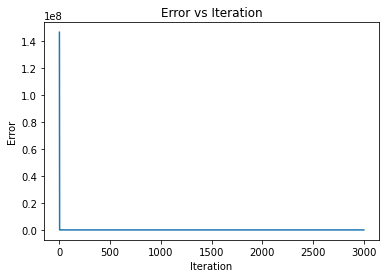

Initial error =  146743944.6636062
Final Error = 0.16224367300774417
Best error 0.16224367300614173


In [184]:
points_2d_1 =  points_2d_1 / points_2d_1[:,2].reshape(-1,1)
P_opt_1, errors_1 = PnP_normalized(points_2d_1, points_3d_1, P_init_1, 3000)
print('Initial error = ',errors_1[0])
print('Final Error =',errors_1[-1])
print('Best error',np.min(errors_1))

In [196]:
points_2d_2, points_3d_2, P_gt_2 = get_correspondences(world_pcd,sample_count=10)
mu, sigma = 0, 0.1
P_init_2 = P_gt_2 + np.random.normal(mu, sigma, (3, 4))

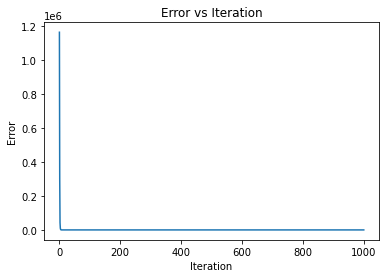

Initial error =  1164602.9519563592
Final Error = 0.021553231233051723
Best error 0.02155321894417853


In [197]:
points_2d_2 =  points_2d_2 / points_2d_2[:,2].reshape(-1,1)
P_opt, errors_2 = PnP_normalized(points_2d_2, points_3d_2, P_init_2, 1000)
print('Initial error = ',errors_2[0])
print('Final Error =',errors_2[-1])
print('Best error',np.min(errors_2))

## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.

In [199]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import cv2


In [250]:
COLOR = [[100,200,0],[0,100,200],[10,255,100],[255,0,0],[0,255,0],[0,0,255],[255,255,0],[0,255,255],[255,0,255],[128,128,0],[0,128,128],[100,0,50],[0,190,33],[1,100,1,],[130,130,200],[16,69,49],[175,250,200]]

def plot_points(points,image):
    
    for i in range(points.shape[0]):
        
        thickness = 10
        colour = COLOR[i]
        
        image = cv2.circle(image,(int(points[i][0]),int(points[i][1])),thickness,colour,-1)
    
    return image

Select the first pair of images (frame1).

In [204]:
LEFT_IMAGE_PATH_1 = "../data/img2/0000000460.png"
RIGHT_IMAGE_PATH_1 = "../data/img3/0000000460.png"

In [205]:
%matplotlib tk
#Opening img1
image_points_left_1 = []
fig = plt.figure(figsize=(20,30))

IMG_LEFT = mpimg.imread(LEFT_IMAGE_PATH_1)

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points_left_1.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(IMG_LEFT)
plt.show()

#Opening img2
image_points_right_1 = []
fig = plt.figure(figsize=(20,30))

IMG_RIGHT = mpimg.imread(RIGHT_IMAGE_PATH_1)

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points_right_1.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)


imgplot = plt.imshow(IMG_RIGHT)
plt.show()

WARNING - 2021-12-02 20:02:01,787 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2021-12-02 20:02:01,801 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


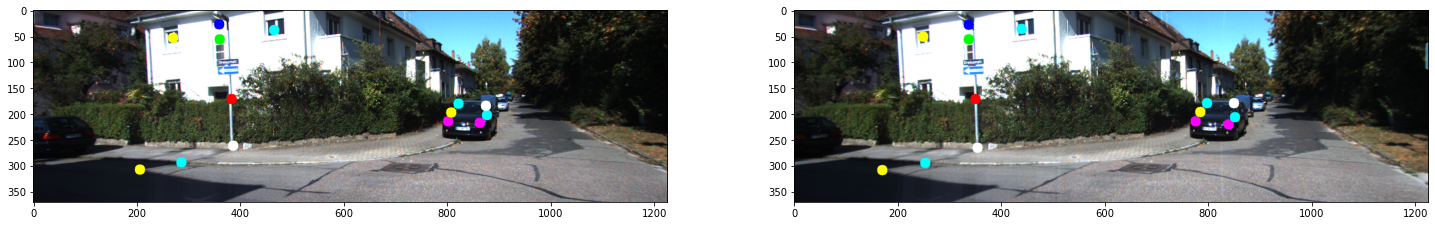

In [251]:
#View the points:

#Points1 - corresponding to image 1
image_points_left_1 = np.array(image_points_left_1)
img1 = mpimg.imread(LEFT_IMAGE_PATH_1)
img1 = plot_points(image_points_left_1,img1)

#Points2 - corresponding to image 2
image_points_right_1 = np.array(image_points_right_1)
img2 = mpimg.imread(RIGHT_IMAGE_PATH_1)
img2 = plot_points(image_points_right_1,img2)

%matplotlib inline
fig, ax = plt.subplots(1,2,figsize=(25,25)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [209]:
image_points_left1 = np.array([[int(i[1]), int(i[0])] for i in image_points_left_1])
image_points_right1 = np.array([[int(i[1]), int(i[0])] for i in image_points_right_1])

print("The points from image1 are:")
print(image_points_left1)
print("The points from image2 are:")
print(image_points_right1)


The points from image1 are:
[[307 206]
 [293 286]
 [261 386]
 [171 383]
 [ 56 360]
 [ 27 359]
 [ 53 270]
 [ 38 465]
 [214 801]
 [197 807]
 [180 821]
 [217 862]
 [202 876]
 [184 874]]
The points from image2 are:
[[308 170]
 [294 253]
 [265 354]
 [171 350]
 [ 56 337]
 [ 28 337]
 [ 51 249]
 [ 36 439]
 [214 775]
 [196 784]
 [179 797]
 [220 839]
 [206 851]
 [179 849]]


Select the second pair of images (frame2).

In [210]:
LEFT_IMAGE_PATH_2 = "../data/img2/0000000463.png"
RIGHT_IMAGE_PATH_2 = "../data/img3/0000000463.png"

In [211]:
%matplotlib tk
#Opening img1
image_points_left_2 = []
fig = plt.figure(figsize=(20,30))

IMG_LEFT = mpimg.imread(LEFT_IMAGE_PATH_2)

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points_left_2.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(IMG_LEFT)
plt.show()

#Opening img2
image_points_right_2 = []
fig = plt.figure(figsize=(20,30))

IMG_RIGHT = mpimg.imread(RIGHT_IMAGE_PATH_2)

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points_right_2.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)


imgplot = plt.imshow(IMG_RIGHT)
plt.show()

WARNING - 2021-12-02 20:02:15,868 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2021-12-02 20:02:15,890 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


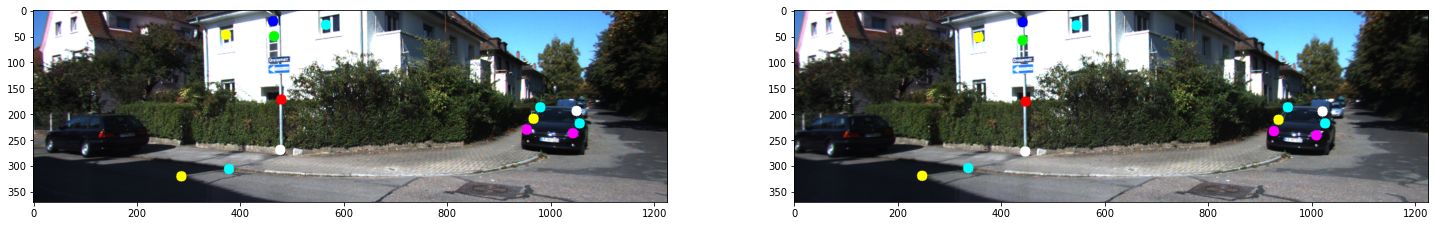

In [252]:
#View the points:

#Points1 - corresponding to image 1
image_points_left_2 = np.array(image_points_left_2)
img1 = mpimg.imread(LEFT_IMAGE_PATH_2)
img1 = plot_points(image_points_left_2,img1)

#Points2 - corresponding to image 2
image_points_right_2 = np.array(image_points_right_2)
img2 = mpimg.imread(RIGHT_IMAGE_PATH_2)
img2 = plot_points(image_points_right_2,img2)

%matplotlib inline
fig, ax = plt.subplots(1,2,figsize=(25,25)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [213]:
image_points_left2 = np.array([[int(i[1]), int(i[0])] for i in image_points_left_2])
image_points_right2 = np.array([[int(i[1]), int(i[0])] for i in image_points_right_2])

print("The points from image1 are:")
print(image_points_left2)
print("The points from image2 are:")
print(image_points_right2)


The points from image1 are:
[[ 320  286]
 [ 306  378]
 [ 269  477]
 [ 172  479]
 [  50  465]
 [  21  463]
 [  47  372]
 [  28  565]
 [ 230  953]
 [ 209  966]
 [ 187  979]
 [ 237 1042]
 [ 218 1055]
 [ 194 1049]]
The points from image2 are:
[[ 319  247]
 [ 304  336]
 [ 272  446]
 [ 176  447]
 [  58  441]
 [  23  441]
 [  52  356]
 [  29  545]
 [ 233  926]
 [ 211  935]
 [ 187  953]
 [ 241 1008]
 [ 218 1025]
 [ 195 1020]]


In [279]:
img1_pts = np.array([[810.15633291, 198.58590281],
 [876.07031141, 202.01000559],
 [820.42864125, 183.1774403 ],
 [873.50223432, 185.74551739],
 [798.17197319, 218.27449379],
 [855.52569474, 224.26667365],
 [382.99951124, 271.34808686],
 [388.9916911,  178.89731183],
 [263.15591398,  65.04589443],
 [456.61772099,  50.49345762],
 [353.03861193,  36.7970465 ],
 [354.75066332,  55.62961179],
 [287.98065913, 295.31680631],
 [204.09014104, 309.86924312]])

img2_pts = np.array([[ 965.95300936,  213.13833962],
 [1054.12365591,  218.27449379],
 [ 979.64942047,  196.01782572],
 [1048.98750175,  197.72987711],
 [ 953.96864963,  236.25103338],
 [1031.01096216,  243.09923893],
 [ 479.73041475,  281.6203952 ],
 [ 487.434646,    181.46538891],
 [ 371.01515152,   65.04589443],
 [ 561.90888144,   47.06935484],
 [ 458.32977238,   34.22896942],
 [ 458.32977238,   51.34948331],
 [ 377.86335707,  307.30116604],
 [ 288.83668482,  320.99757715]]
)

img1_pts = img1_pts.round(0)
img2_pts = img2_pts.round(0)

image_points_left1 = img1_pts.astype(int)
image_points_left2 = img2_pts.astype(int)

image_points_right1 = img1_pts.astype(int)
image_points_right2 = img2_pts.astype(int)


In [280]:
def procrustes_alignment(pts1, pts2):
    # ptCloud1, ptCloud2 are of size 3 x n

    dim, N = pts1.shape
    centre1 = np.mean(pts1, axis = 1)[..., None]
    centre2 = np.mean(pts2, axis = 1)[..., None]
    
    pts1_centred = pts1 - centre1
    pts2_centred = pts2 - centre2

    S = pts1_centred @ pts2_centred.T
    U, D, Vt = np.linalg.svd(S)
    R = U @ Vt

    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = U @ Vt

    t = centre1 - R @ centre2

    T = np.eye(4)
    T[:3, :3], T[:3, 3] = R, t[:, 0]

    return T, R, t

def get_3d_points(img_left, img_right, image_points_left, image_points_right):

    disparity = make_disparitymap(img_left, img_right)
    h, w = disparity.shape[:2]
    f = K[0][0]
    rev_proj_matrix = np.float32([[1, 0, 0, -0.5*w],
                        [0,-1, 0,  0.5*h],
                        [0, 0, 0, -f],
                        [0, 0, -1/BASELINE,  0]])
    
    disparity_map = np.array([[item[0], item[1], disparity[item[1], item[0]], 1] for item in image_points_left])
    
    # item[1] should be less than 300
    points_3d = np.array([rev_proj_matrix @ item for item in disparity_map])
    points_3d = (points_3d.T/points_3d.T[-1, :]).T
    points_3d[:, 0] *= -1
    # points_3d[:, 1] *= -1
    
    return points_3d

### Optimizing with ICP
First we obtain the 3D points  for left images of 460th and 463th frame using disparity maps of their respective pair of images. Then we feed these 3D points into ICP to estimate relative pose between them.

In [281]:
# MAIN 
img_left1 = cv2.imread(LEFT_IMAGE_PATH_1)
img_right1 = cv2.imread(RIGHT_IMAGE_PATH_1)

img_left2 = cv2.imread(LEFT_IMAGE_PATH_2)
img_right2 = cv2.imread(RIGHT_IMAGE_PATH_2)


points_3d_frame1 = get_3d_points(img_left1, img_right1, image_points_left1, image_points_right1)
points_3d_frame2 = get_3d_points(img_left2, img_right2, image_points_left2, image_points_right2)

#ICP:
T, R, t = procrustes_alignment(points_3d_frame1[:, :3].T, points_3d_frame2[:, :3].T)

print("T:", T, "\nR:", R, "\nt:", t)
print("Frame 460:\n", points_3d_frame1)
print("Frame 463:\n", points_3d_frame2)

T: [[ 9.99685117e-01  1.60293528e-02 -1.93061115e-02 -1.89603650e+02]
 [-1.64928876e-02  9.99573623e-01 -2.40947550e-02  1.73487482e+01]
 [ 1.89116565e-02  2.44055815e-02  9.99523245e-01  2.03437838e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
R: [[ 0.99968512  0.01602935 -0.01930611]
 [-0.01649289  0.99957362 -0.02409476]
 [ 0.01891166  0.02440558  0.99952324]] 
t: [[-189.60364974]
 [  17.3487482 ]
 [  20.34378377]]
Frame 460:
 [[ 3.37571211e+02  2.39898323e+01  1.21164278e+03  1.00000000e+00]
 [ 4.47418397e+02  2.89205808e+01  1.20291105e+03  1.00000000e+00]
 [ 3.56307928e+02 -3.44258867e+00  1.21711206e+03  1.00000000e+00]
 [ 4.46313389e+02  1.71001298e+00  1.20913511e+03  1.00000000e+00]
 [ 3.13219124e+02  5.58715194e+01  1.19715936e+03  1.00000000e+00]
 [ 4.11136751e+02  6.59849106e+01  1.19634227e+03  1.00000000e+00]
 [-3.83126816e+02  1.43256114e+02  1.17785041e+03  1.00000000e+00]
 [-3.72881603e+02 -9.98790008e+00  1.17705935e+03  1.00000000e+00]
 [

Here we are calculating P using estimated [R,t] (by ICP), then we are projecting this P to compare the generated 2D points with the actual 2D points. Finally we compute error.  
This P projects 3D points from 463's camera frame onto 460's image frame.

In [282]:
P_icp = K @ np.hstack((R, t))

x = points_3d_frame2 @ P_icp.T
x = (x.T/x.T[-1, :]).T
x = x[:, :2]

print("Ground truth 2D points generated above by clicking (460th left frame):\n", image_points_left1)
print("\nAfter projecting:\n", x)

error_in_proj = (x - image_points_left1) ** 2
print("\nError in projection(After ICP):",np.sum(error_in_proj))
error_icp = np.sum(error_in_proj)


Ground truth 2D points generated above by clicking (460th left frame):
 [[810 199]
 [876 202]
 [820 183]
 [874 186]
 [798 218]
 [856 224]
 [383 271]
 [389 179]
 [263  65]
 [457  50]
 [353  37]
 [355  56]
 [288 295]
 [204 310]]

After projecting:
 [[822.38454889 198.18935889]
 [905.96260124 201.71536211]
 [836.21805023 181.38237099]
 [901.54225679 182.33847106]
 [809.1248693  220.90132806]
 [882.44773072 226.46142317]
 [345.56967916 274.26502207]
 [350.36899504 174.80944487]
 [239.74355084  60.47990241]
 [427.80282773  40.36123055]
 [324.81745572  28.57241269]
 [325.14031432  45.54788383]
 [241.89639938 300.95442082]
 [151.13492002 316.62295438]]

Error in projection(After ICP): 14221.202701494754


Now we will try to refine(optimise) this obtained P using PnP so that we can further decrease the error computed above. The new P after PnP must have an error less than '14221.202701494754'.

### Optimizing with PnP:

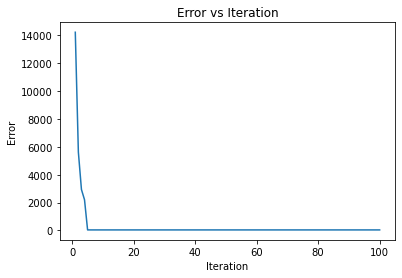

Initialised P (obtained after ICP)=
 [[ 7.18251235e+02  2.60236239e+01  5.87949166e+02 -1.21822407e+05]
 [-8.19905471e+00  7.11258628e+02  1.65985912e+02  1.59923056e+04]
 [ 1.89116565e-02  2.44055815e-02  9.99523245e-01  2.03437838e+01]]
Initial error value = 14221.202701494754

Final optimised P (obtained after PnP)=
 [[ 5.16120141e+04  7.84369800e+03  3.64984665e+04 -1.15681449e+05]
 [ 9.97823539e+02  4.85005293e+04  1.29776695e+04  1.56609006e+04]
 [ 9.74869758e+00  1.55955748e+01  7.18210878e+01  1.92226944e+01]]
The final error value = 39.46739498364573


In [283]:
%matplotlib inline

P_init_pnp = P_icp.reshape((12, 1))
points_2d = np.hstack((image_points_left1, np.ones((image_points_left1.shape[0], 1))))
points_3d = points_3d_frame2

P_pnp, error_pnp = PnP_normalized(points_2d, points_3d, P_init_pnp)
P_pnp = P_pnp.reshape((3, 4))


print("Initialised P (obtained after ICP)=\n",P_init_pnp.reshape((3,4)))
print("Initial error value =",error_icp)
print("\nFinal optimised P (obtained after PnP)=\n", P_pnp)
print("The final error value =", error_pnp[-1])

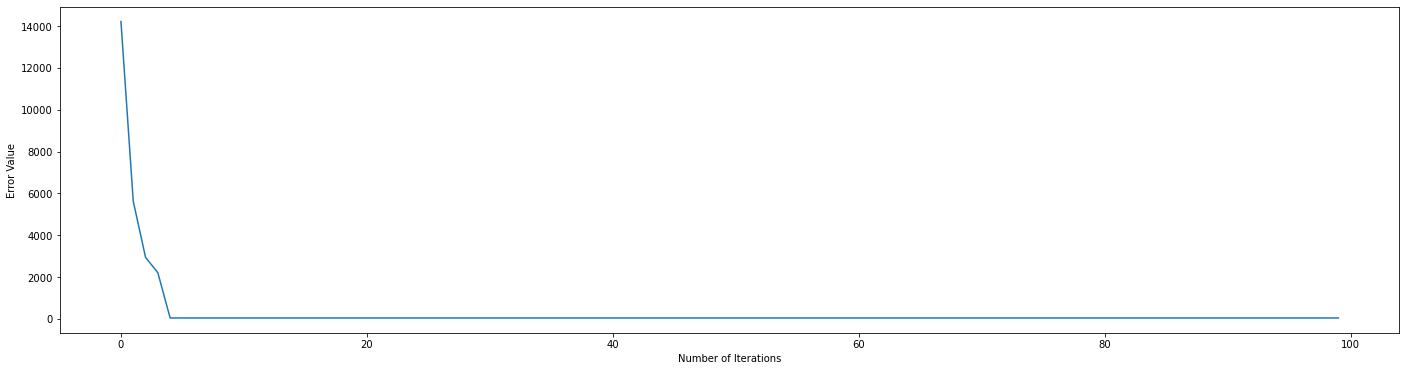

In [284]:
ROWS, COLS = 1, 3
H, W = 6, 8

fig, ax = plt.subplots(figsize = (COLS*W, ROWS*H))

ax.set_xlabel("Number of Iterations")
ax.set_ylabel("Error Value")
ax.plot(error_pnp)

Here we are projecting this P (Final estimate) to compare the generated 2D points with the actual 2D points

In [285]:
x_pnp = points_3d_frame2 @ P_pnp.T
x_pnp = (x_pnp.T/x_pnp.T[-1, :]).T
x_pnp = x_pnp[:, :2]

print("Ground truth 2D points generated above by clicking (460th left frame):\n", image_points_left1)
print("\nAfter projecting:\n", x_pnp)

error_in_proj_final = (x_pnp - image_points_left1) ** 2
print(np.sum(error_in_proj_final))

Ground truth 2D points generated above by clicking (460th left frame):
 [[810 199]
 [876 202]
 [820 183]
 [874 186]
 [798 218]
 [856 224]
 [383 271]
 [389 179]
 [263  65]
 [457  50]
 [353  37]
 [355  56]
 [288 295]
 [204 310]]

After projecting:
 [[808.02095646 199.29203139]
 [876.78484354 201.87948359]
 [820.73458857 184.9015129 ]
 [875.00435866 185.54932335]
 [796.44825659 218.51216179]
 [856.39441297 222.60927253]
 [384.88348892 269.69715912]
 [387.89893372 179.09670114]
 [264.39683337  67.08273757]
 [457.49887008  50.70925225]
 [352.8239003   36.37540709]
 [353.66566574  53.64182755]
 [288.90903496 294.96996003]
 [202.53578356 310.683136  ]]
39.46739498364593


Hence after optimizing P further, we reach to a P such that error between actual 2D points and projected 2D points is '39.4673949836472'